# Dependencies

In [28]:
import pandas as pd
!pip -q install seaborn
import seaborn as sns
!pip install -q missingno
import matplotlib.pyplot as plt
import missingno as msno
!pip -q install scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer
!pip -q install pycountry
import pycountry
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score



<h2> Predict whether a security alert represents a real (true positive) threat that requires investigation, or if it's a false/benign positive that can be safely ignored.</h2>

IncidentGrade, mapped to a binary label:

1 = TruePositive → Confirmed threat (requires escalation)

0 = FalsePositive or BenignPositive → No threat (routine or noisy alert)

# Explore 

In [29]:
Data=pd.read_csv("GUIDE_Train.csv")
df=Data.copy()

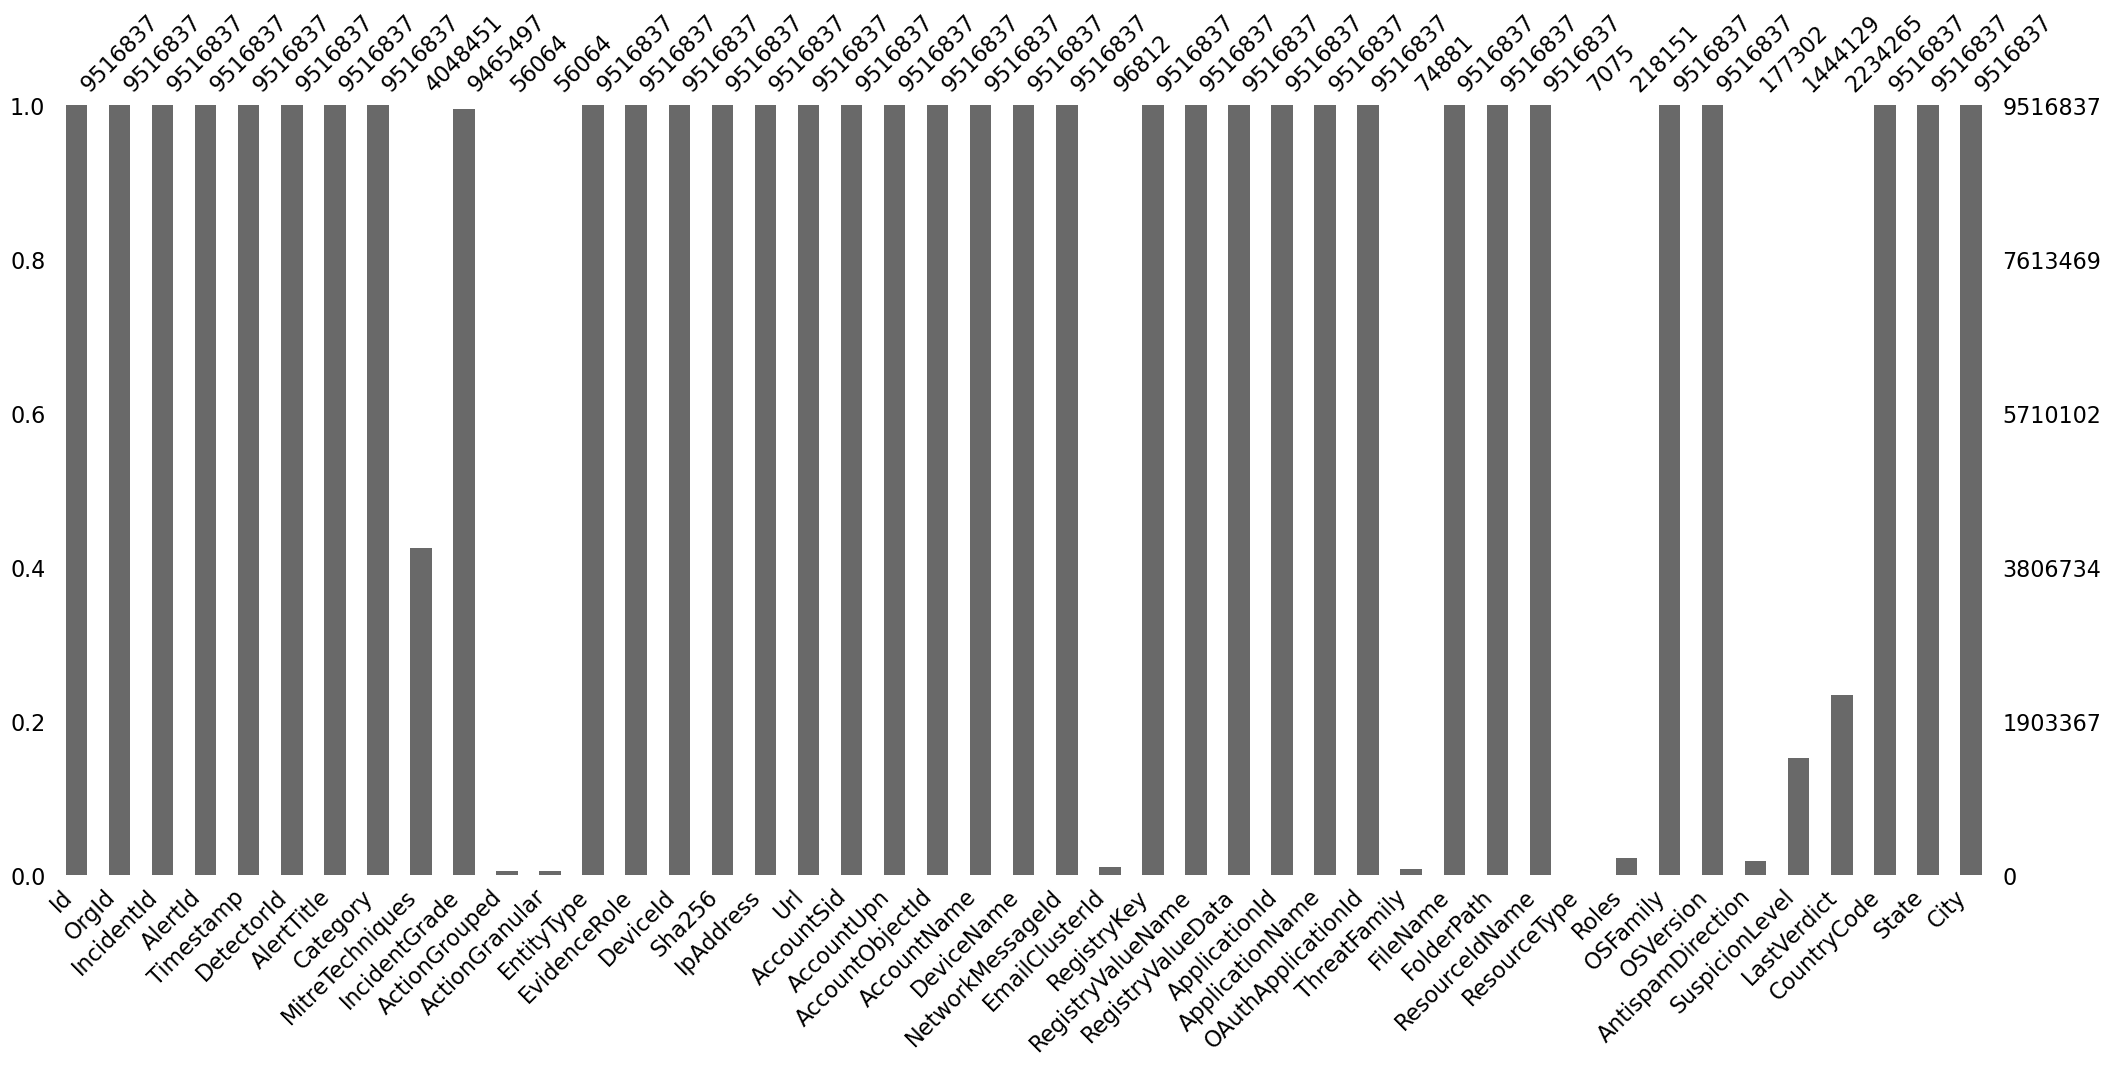

In [30]:
import matplotlib.pyplot as plt
import missingno as msno
plt.figure(figsize=(3, 3))  # width x height in inches
msno.bar(df)
plt.show()


In [31]:
print(f"⚫ Columns are{df.columns}")

print("---------------------------------------------")

print(f" ⚫ We have an {len(df.columns)} columns in the Data ")
print(f" ⚫ We have an {df.select_dtypes(include='object').shape[1]} Categorial Columns at in the Data ")
print(f" ⚫ We have an {df.select_dtypes(include=['int','float']).shape[1] } integer Columns at in the Data ")
cate=df.select_dtypes(include='object') 
numc=df.select_dtypes(include=['int','float'])

print(f"⚫ Integer Columns  {numc.columns}")
print(f"⚫ Categorial Columns{cate.columns}")
df.shape

⚫ Columns areIndex(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')
---------------------------------------------
 ⚫ We have an 45 columns in the Data 
 ⚫ We have an 14 Categorial Columns at in the Data 
 ⚫ We have an 31 integer Columns at in the Data 
⚫ Integer Columns  Index(['Id', 'OrgId', 

(9516837, 45)

BinaryIncidentGrade  Target Variable 

IncidentGrade, mapped to a binary label:

1 = TruePositive → Confirmed threat (requires escalation)

0 = FalsePositive or BenignPositive → No threat (routine or noisy alert)

In [32]:
df['BinaryIncidentGrade'] = df['IncidentGrade'].apply(lambda x: 1 if x == 'TruePositive' else 0)
alert_risk = df.groupby('AlertTitle')['BinaryIncidentGrade'].mean()
d=df.drop(columns=['IncidentGrade'])


In [33]:
counts = df['BinaryIncidentGrade'].value_counts()
percentages = df['BinaryIncidentGrade'].value_counts(normalize=True).mul(100).round(2)

result = pd.DataFrame({'Count': counts, 'Percentage': percentages})
print(result)


                       Count  Percentage
BinaryIncidentGrade                     
0                    6194124       65.09
1                    3322713       34.91


What is Wilson/Bayes smoothing ?
 
It's a corrected average that prevents misleading extremes when we have very few data points.
AlertTitle 101

Incidents: 2

Total Alerts: 2

Raw Risk = 2 / 2 = 1.0

Smoothed:0.666
Why?

* Because with only 2 examples, we shouldn't fully trust 100% risk — the smoothed value brings it closer to 0.5 to reflect uncertainty.
​


In [34]:
alert_risk2 = df.groupby('AlertTitle')['BinaryIncidentGrade'].sum()
alert_summary = pd.DataFrame({
    'Risk': alert_risk,
    'Count': alert_risk2
})

alpha = 2
beta = 2

# Calculate smoothed risk
alert_summary['SmoothedRisk'] = (
    alert_summary['Risk'] * alert_summary['Count'] + alpha
) / (alert_summary['Count'] + alpha + beta)

alert_summary
SmoothedRisk=alert_summary.SmoothedRisk
df=df.merge(SmoothedRisk,on='AlertTitle' , how ='left')

# EDA

Target variable BinaryIncidentGrade is imbalanced.

Class 0 represents approximately 65% of the data.

Class 1 (minority) accounts for about 35%.

Moderate class imbalance

I chose not to manually address class imbalance through resampling, as we used tree-based ensemble models (Random Forest /LightGBM) that support imbalance-aware training via the scale_pos_weight or class_weight parameters. This allows the model to adjust for skewed class distributions internally while preserving the true data structure.”



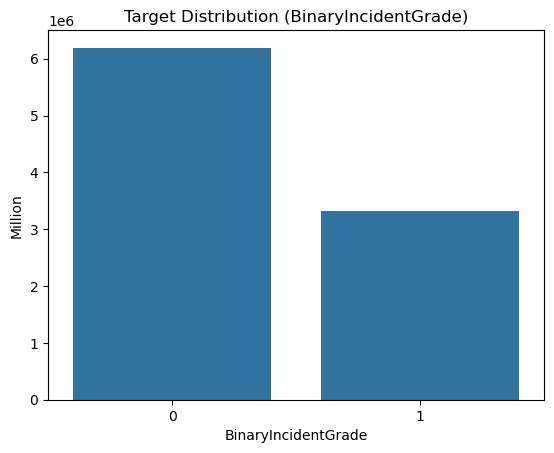

In [35]:
# Target distribution
sns.countplot(x='BinaryIncidentGrade', data=df)
plt.title("Target Distribution (BinaryIncidentGrade)")
plt.ylabel("Million")
plt.show()




-Smoothed risk values are distributed for each class. Higher smoothed risk scores are more concentrated among the positive class

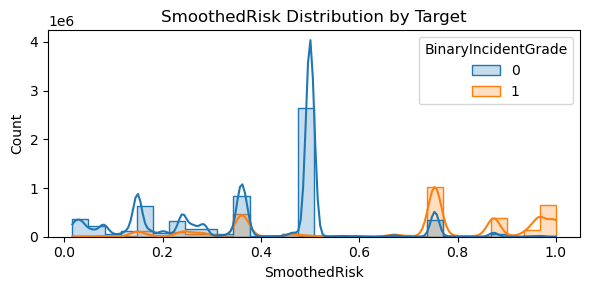

In [36]:
plt.figure(figsize=(6, 3))
sns.histplot(data=df, x='SmoothedRisk', hue='BinaryIncidentGrade', bins=30, kde=True, element='step',  common_norm=False)
plt.title("SmoothedRisk Distribution by Target")
plt.tight_layout()
plt.show()


Hours and Week days might be important Features at the Security Incident 

In [37]:
print(max(df.Timestamp)), print(min(df.Timestamp))
df['Timestamp']=pd.to_datetime(df['Timestamp'])
df['month']=df['Timestamp'].dt.month
df['hour']=df['Timestamp'].dt.hour
df['weekday']=df['Timestamp'].dt.weekday+1
df=df.drop(columns=['Timestamp'])

2024-06-17T14:45:38.000Z
2023-11-20T16:32:22.000Z


In [38]:
cate=df.select_dtypes(include='object') 

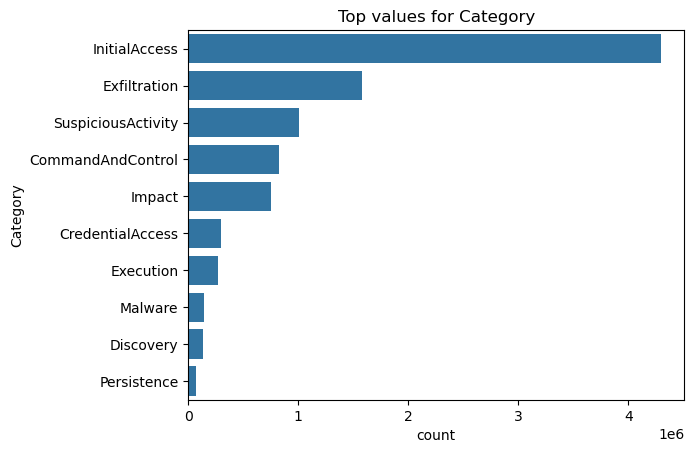

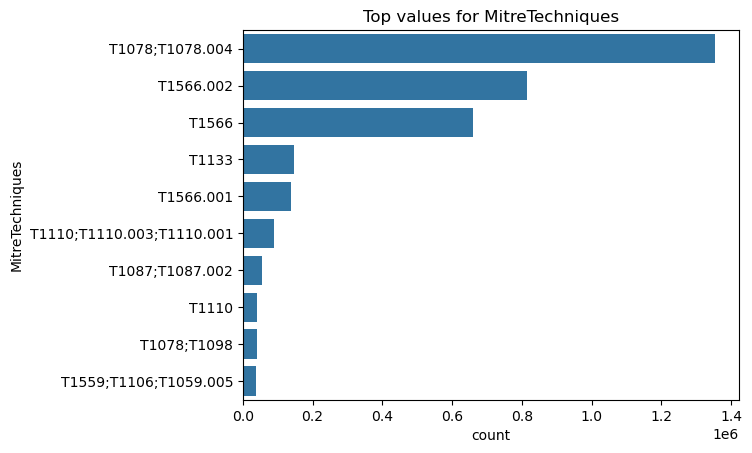

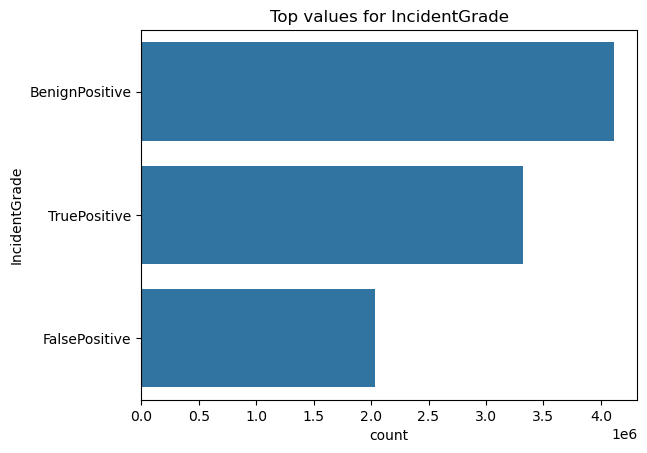

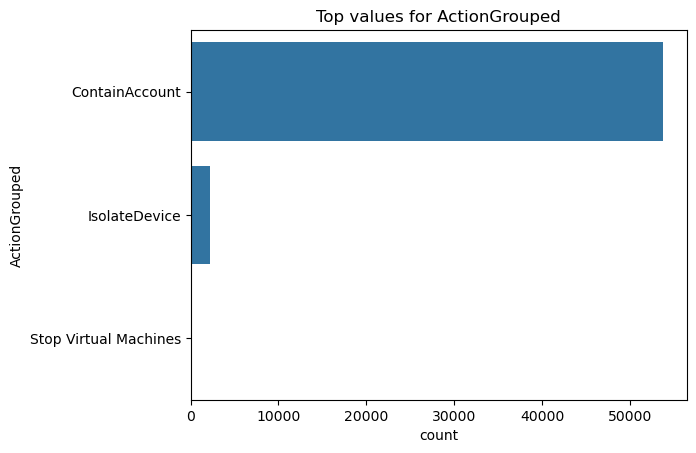

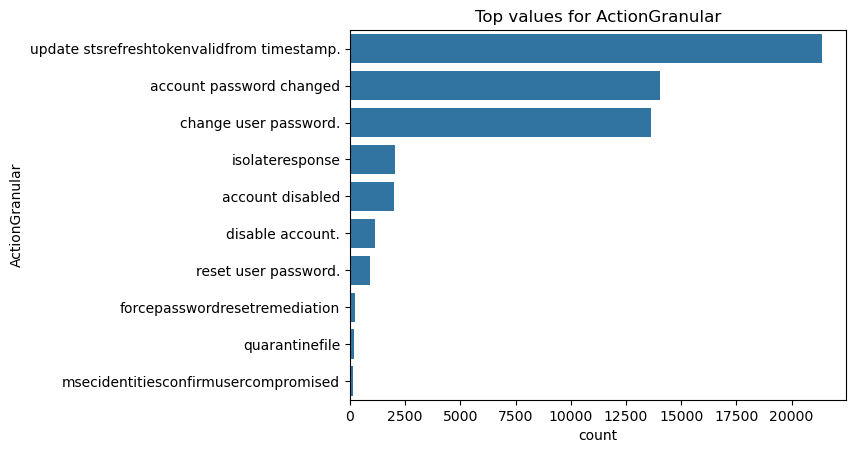

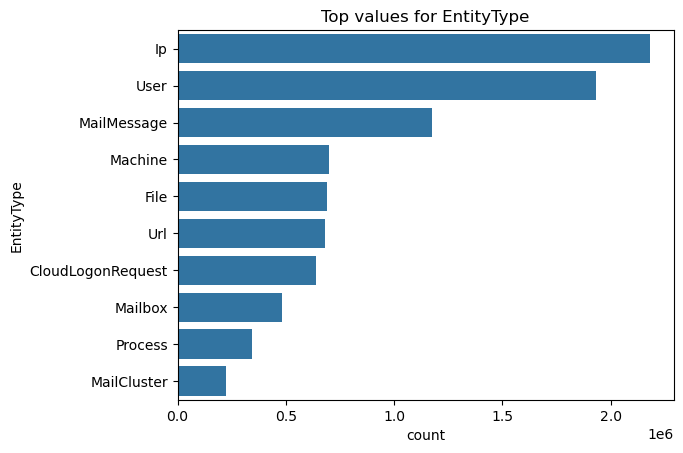

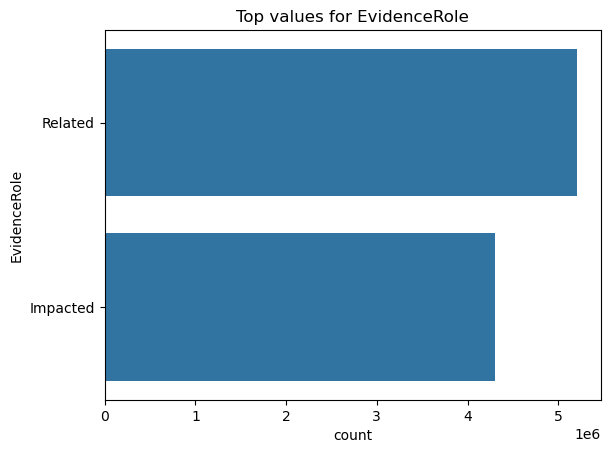

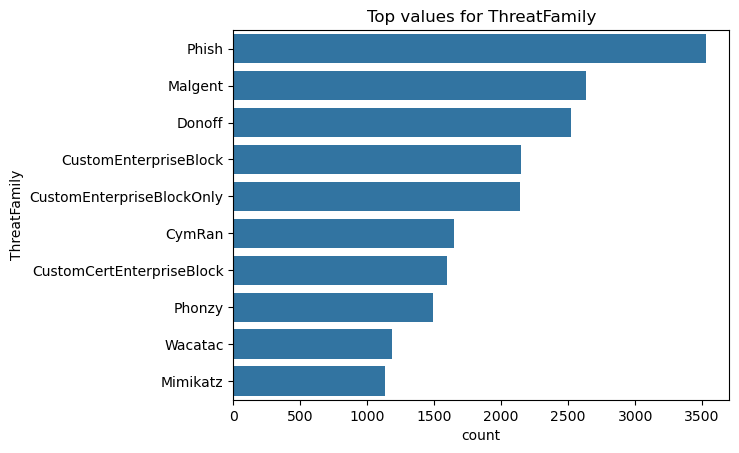

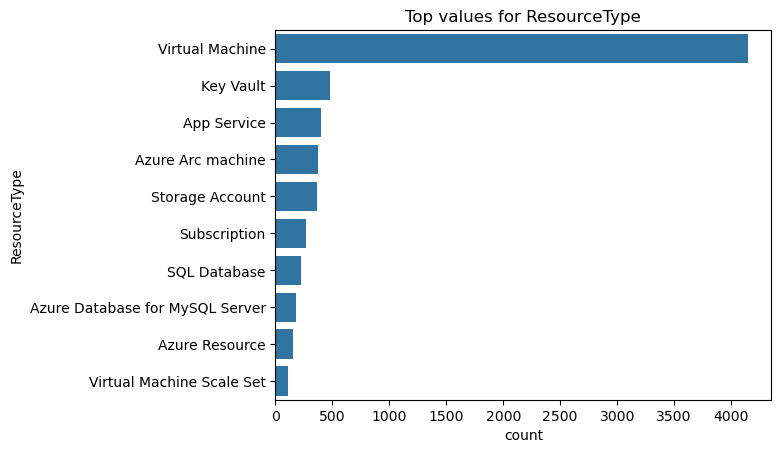

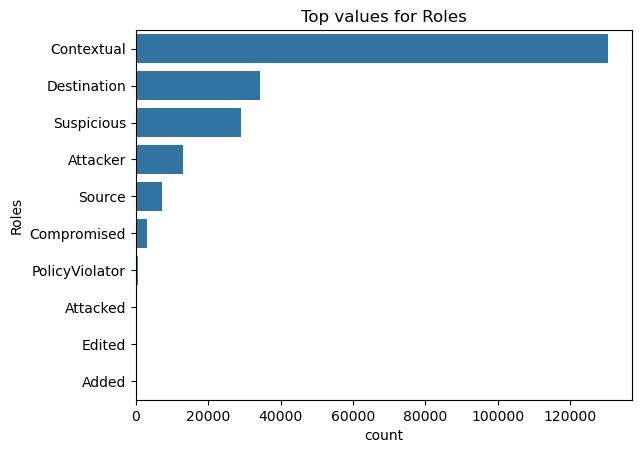

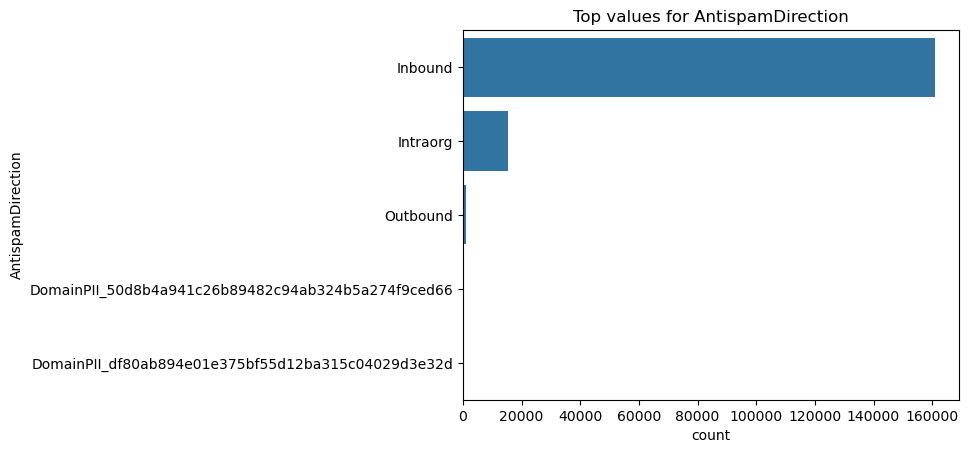

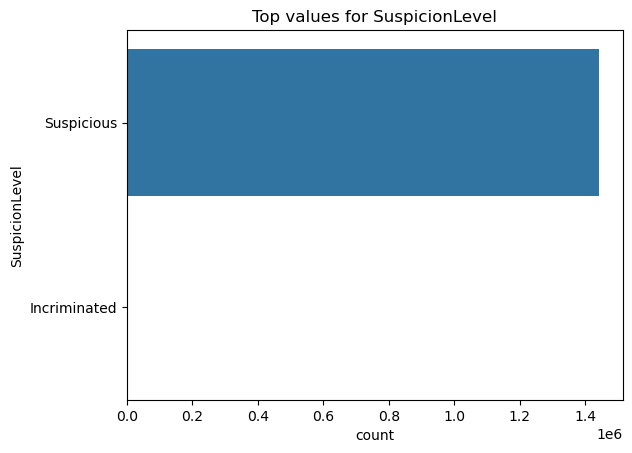

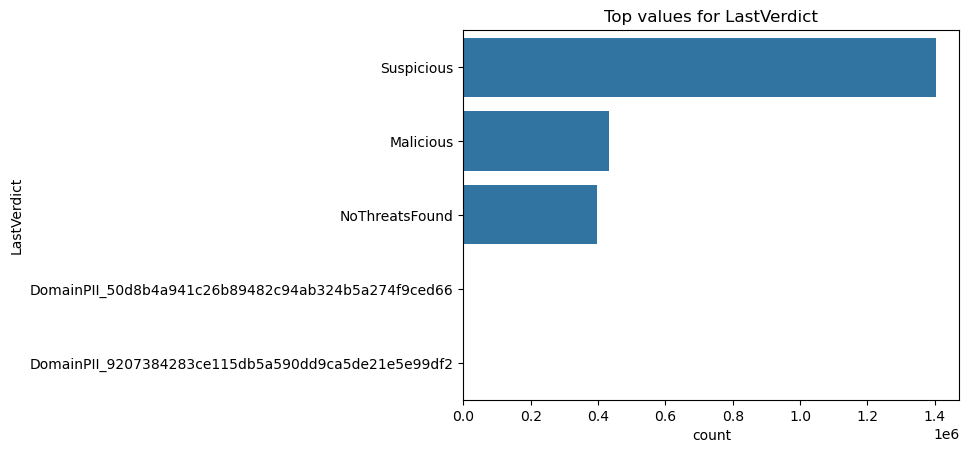

In [39]:
for col in cate:
    sns.countplot(y=col, data=df, order=df[col].value_counts().iloc[:10].index)
    plt.title(f"Top values for {col}")
    plt.show()
 

Tried to match the country codes using Microsoft's ISO database standards, but the mapping was incorrect. Fiji Island alone has 8,766,912 rows — about 90% of the data. This suggests that the city with code 1445 (which has 8,883,778 rows) is likely located in Fiji.

In [40]:
def code_to_country(code):
    try:
        return pycountry.countries.get(numeric=str(code).zfill(3)).name
    except:
        return 'Unknown'
    
n=df.copy()
n['CountryName'] = n['CountryCode'].apply(code_to_country)
n['CountryName'].value_counts()


CountryName
Fiji                                            8766912
Unknown                                          614719
Afghanistan                                       40295
Albania                                           17934
Antarctica                                        15850
                                                 ...   
South Georgia and the South Sandwich Islands          1
Falkland Islands (Malvinas)                           1
Ecuador                                               1
Estonia                                               1
Cuba                                                  1
Name: count, Length: 70, dtype: int64

In [41]:
state_counts = df['State'].value_counts()
state_counts.head(10)


State
1445    8883778
0        103868
1         40312
2         28875
3         23048
4         19133
5         15771
6         15579
7         14495
8         12481
Name: count, dtype: int64

This feature engineering step adds a geolocation frequency feature, which can be useful  to indicate how common a particular location is in the dataset—potentially useful for detecting rare locations or regional patterns.

CountryCode, State, and City into a single GeoLoc identifier, then calculates the normalized frequency of each unique location. The resulting frequency (GeoLoc_freq) is added to the DataFrame, and the original location columns are dropped.

In [42]:
df['GeoLoc'] = df['CountryCode'].astype(str) + "_" + df['State'].astype(str) + "_" + df['City'].astype(str)
geo_freq = df['GeoLoc'].value_counts(normalize=True)
df['GeoLoc_freq'] = df['GeoLoc'].map(geo_freq)
df.drop(columns=['CountryCode', 'State', 'City', 'GeoLoc'], inplace=True)

# Confirm result
df[['GeoLoc_freq']].describe()

,GeoLoc_freq
count,9.516837e+06
mean,8.487095e-01
std,2.476605e-01
min,1.050769e-07
25%,9.211619e-01
50%,9.211619e-01
75%,9.211619e-01
max,9.211619e-01


# Explore The Categorial Features



⚠️ Some rare values   Examples  Roles(Added, Edited, PolicyViolator) occur <10×

grouping rare roles into "Other" before encoding

This code fills missing values in specific columns of a DataFrame (df) with the string 'missing' or 'Missing'. Then, it groups infrequent values (less than 100 occurrences) in the LastVerdict column under a common label 'Other' and shows the count of unique values in selected columns.

In [43]:
df['Roles']=df.Roles.fillna('missing')
df['ActionGrouped'] = df['ActionGrouped'].fillna('Missing')
df['SuspicionLevel'] = df['SuspicionLevel'].fillna('Missing')
df['LastVerdict'] = df['LastVerdict'].fillna('Missing')
# Group rare verdicts
verdict_counts = df['LastVerdict'].value_counts()
rare_verdicts=verdict_counts[verdict_counts<100].index
df['LastVerdict'] = df['LastVerdict'].replace(rare_verdicts, 'Other')
df[['Roles', 'ActionGrouped', 'SuspicionLevel', 'LastVerdict']].nunique()

Roles             11
ActionGrouped      4
SuspicionLevel     3
LastVerdict        6
dtype: int64

<h3>Frequent Encoding </h3>

Many of the columns (e.g., 'ThreatFamily', 'Category', 'LastVerdict') likely contain a large number of unique values. One-hot encoding would create a new column for each unique category, massively increasing the feature space and memory usage and may casue curse of dimensionality. Frequency gives us a simple, bounded signal

In [44]:
cols = [
    'ThreatFamily', 'AntispamDirection', 'ActionGranular',
    'LastVerdict', 'ResourceType', 'Roles', 'ActionGrouped', 'EntityType','Category' 
]

for col in cols:
    print(f"\n📊 Analyzing column: {col}")
    print("🔹 Unique Values:", df[col].nunique())
    print("\n🔹 Top 10 Values:\n", df[col].value_counts().head(10))
    print("\n🔹 Missing Ratio:", df[col].isna().mean())
    print("\n🔹 Target Mean by Category:\n", df.groupby(col)['BinaryIncidentGrade'].mean().sort_values(ascending=False))
    print("🔹 Rare Categories (<100 rows):", sum(df[col].value_counts() < 100))
    
    # Fill missing
    df[col] = df[col].fillna('Missing')

    # Frequency encode
    freq = df[col].value_counts(normalize=True)
    df[f"{col}_freq"] = df[col].map(freq)

    # Drop original
    df.drop(columns=col, inplace=True)



📊 Analyzing column: ThreatFamily
🔹 Unique Values: 1745

🔹 Top 10 Values:
 ThreatFamily
Phish                        3526
Malgent                      2636
Donoff                       2519
CustomEnterpriseBlock        2145
CustomEnterpriseBlockOnly    2139
CymRan                       1648
CustomCertEnterpriseBlock    1595
Phonzy                       1493
Wacatac                      1185
Mimikatz                     1131
Name: count, dtype: int64

🔹 Missing Ratio: 0.9921317345248216

🔹 Target Mean by Category:
 ThreatFamily
Evidpatch        1.0
Epatch           1.0
Roduk            1.0
CVE-2009-3867    1.0
Remeshelsz       1.0
                ... 
DarkCloud        0.0
Neoreblamy       0.0
DarkBit          0.0
Neshta           0.0
Locky            0.0
Name: BinaryIncidentGrade, Length: 1745, dtype: float64
🔹 Rare Categories (<100 rows): 1614

📊 Analyzing column: AntispamDirection
🔹 Unique Values: 5

🔹 Top 10 Values:
 AntispamDirection
Inbound                                          

In [45]:
cols = ['SuspicionLevel', 'EvidenceRole']

for col in cols:
    print(f"\n📊 Analyzing column: {col}")
    print("🔹 Unique Values:", df[col].nunique())
    print("\n🔹 Top 10 Values:\n", df[col].value_counts().head(10))
    print("\n🔹 Missing Ratio:", df[col].isna().mean())
    print("\n🔹 Target Mean by Category:\n", df.groupby(col)['BinaryIncidentGrade'].mean().sort_values(ascending=False))
    print("🔹 Rare Categories (<100 rows):", sum(df[col].value_counts() < 100))
    
    # Fill missing
    df[col] = df[col].fillna('Missing')
    
    # Group rare categories
    counts = df[col].value_counts()
    rare = counts[counts < 100].index

    df[col] = df[col].replace(rare, 'Other')
    
    # One-hot encode
    df = pd.get_dummies(df, columns=[col], drop_first=True)



📊 Analyzing column: SuspicionLevel
🔹 Unique Values: 3

🔹 Top 10 Values:
 SuspicionLevel
Missing         8072708
Suspicious      1442614
Incriminated       1515
Name: count, dtype: int64

🔹 Missing Ratio: 0.0

🔹 Target Mean by Category:
 SuspicionLevel
Missing         0.372889
Suspicious      0.216546
Incriminated    0.064686
Name: BinaryIncidentGrade, dtype: float64
🔹 Rare Categories (<100 rows): 0

📊 Analyzing column: EvidenceRole
🔹 Unique Values: 2

🔹 Top 10 Values:
 EvidenceRole
Related     5208644
Impacted    4308193
Name: count, dtype: int64

🔹 Missing Ratio: 0.0

🔹 Target Mean by Category:
 EvidenceRole
Related     0.418333
Impacted    0.265486
Name: BinaryIncidentGrade, dtype: float64
🔹 Rare Categories (<100 rows): 0


Identify and handle missing or improperly formatted entries.

In [57]:
value_counts = df['MitreTechniques'].value_counts()
total_rows = len(df)

# Create a new Series with percentage values
percentages = (value_counts / total_rows) * 100

# Optionally combine with counts for readability
technique_stats = pd.DataFrame({
    'count': value_counts,
    'percentage': percentages
})

print(f" Missing are  {df['MitreTechniques'].isna().sum()}"), 
print(technique_stats.head(5))

 Missing are  5468386
                   count  percentage
MitreTechniques                     
T1078;T1078.004  1354904   14.236915
T1566.002         814308    8.556498
T1566             659591    6.930780
T1133             145579    1.529699
T1566.001         136892    1.438419


This section processes the MitreTechniques column by splitting multiple techniques into lists, selecting the top 30 most frequent techniques, and filtering each entry accordingly. It then applies one-hot encoding to convert these techniques into binary features

In [58]:
# Step 1: Split the semicolon-separated string into lists
df['MitreList'] = df['MitreTechniques'].apply(lambda x: x.split(';') if pd.notna(x) else [])

# Step 2: Identify top 30 most common techniques
all_techs = [tech for sublist in df['MitreList'] for tech in sublist]
top_techs = [tech for tech, _ in Counter(all_techs).most_common(30)]
top_tech_set = set(top_techs)

# Step 3: Filter each list to include only top techniques
df['FilteredMitreList'] = df['MitreList'].apply(lambda x: [tech for tech in x if tech in top_tech_set])

# Step 4: One-hot encode using MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=top_techs)
tech_matrix = pd.DataFrame(mlb.fit_transform(df['FilteredMitreList']),
                           columns=mlb.classes_, index=df.index)

# Step 5: Merge encoded columns into df and drop original string columns
df = pd.concat([df, tech_matrix], axis=1)
df.drop(columns=['MitreTechniques', 'MitreList', 'FilteredMitreList'], inplace=True)

This columns have been transformed , so it will be dropped to Prevent Data leakeage (Target Leakage) Type 

In [22]:
df.select_dtypes(include="object")


,IncidentGrade
0,TruePositive
1,FalsePositive
2,FalsePositive
3,BenignPositive
4,TruePositive
...,...
9516832,TruePositive
9516833,BenignPositive
9516834,BenignPositive
9516835,BenignPositive


# Building Model

These are IDs or hashed keys , IpAddress, URL, EmailClusterId, not true numeric features. They:

Have no semantic meaning

Won’t generalize across samples




In [59]:
drop_redundant = ['Id','IncidentId','Sha256','DeviceId','AccountSid', 'AccountUpn', 'AccountObjectId', 
    'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryValueName', 'RegistryKey', 'ApplicationId','OAuthApplicationId', 'FileName',
    'ResourceIdName', 'EmailClusterId','IncidentGrade', 'OrgId','DetectorId', 'AlertId']

In [60]:


X = df.drop(columns=drop_redundant + ['BinaryIncidentGrade'])
y = df['BinaryIncidentGrade']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_valid.shape)
print(y_train.mean(), y_valid.mean())


(7613469, 55) (1903368, 55)
0.3491404509560622 0.34914057607357063


In [61]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import pandas as pd

# Sample from df if it's very large (you already did this)
d_sample = df.sample(n=100000, random_state=42)  # Optional: set random_state for reproducibility

X= d_sample.drop(columns=drop_redundant + ['BinaryIncidentGrade'])
y = d_sample['BinaryIncidentGrade']

# For classification:
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# For regression tasks, uncomment below and comment out the classification line
# mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=42)

# Wrap results in a Series and sort
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

print(mi_series)


SmoothedRisk                 0.321307
AlertTitle                   0.285184
Category_freq                0.089015
EntityType_freq              0.078404
IpAddress                    0.064138
GeoLoc_freq                  0.061860
T1078.004                    0.055296
T1078                        0.044237
FolderPath                   0.028566
Url                          0.026387
EvidenceRole_Related         0.019970
LastVerdict_freq             0.018354
SuspicionLevel_Missing       0.017433
ResourceType_freq            0.016026
ThreatFamily_freq            0.014818
RegistryValueData            0.013221
month                        0.013070
OSVersion                    0.012844
ActionGrouped_freq           0.012615
OSFamily                     0.012127
Roles_freq                   0.011736
ActionGranular_freq          0.010416
AntispamDirection_freq       0.010107
ApplicationName              0.010078
SuspicionLevel_Suspicious    0.009640
T1133                        0.006659
weekday     

Since the dataset is Big and it will take a long time for Mutual information 

I tried Use a Tree-Based Model for Feature Importance

In [62]:
from sklearn.ensemble import RandomForestClassifier

X= df.drop(columns=drop_redundant + ['BinaryIncidentGrade'])
y = df['BinaryIncidentGrade']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [300, 600, 750],
    'criterion': ['gini', 'entropy']
}

In [ ]:
import time
print("🚀 Starting cross-validation training...")

start = time.time()
# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=6),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=2
)
grid_search.fit(X_train, y_train)

end = time.time()

duration = end - start

In [ ]:
print(f"⏱️ Grid search completed in {duration:.2f} seconds")

# Results
print("✅ Best parameters found:")
print(grid_search.best_params_)

print(f"🎯 Best ROC AUC score from CV: {grid_search.best_score_:.4f}")

# Optional: Evaluate on the held-out validation set
best_model = grid_search.best_estimator_
y_valid_pred = best_model.predict_proba(X_valid)[:, 1]
valid_auc = roc_auc_score(y_valid, y_valid_pred)
print(f"📊 ROC AUC on validation set: {valid_auc:.4f}")

Notes

How To Think When Building The Model 

Classification , Regresstion , Anaomly detection 

How many Rows, any missing features

Many Categorial Features Cat Boost

Baseline Logisitic Regresstion

You care about the Performance XGBOOST, LightGBM 

Small data linear Regresstion or decision Tree

How does SMOTE works  for each minority class it finds the K Nearest Neighbors

It generate a one from the original and the Neighbor  between them   number of Neighbor for samples + 50 thats mean we choose  5 Neighbor    less than 5  (1-3) Neighbor  ( preserving local structure — helpful when data is scarce)

SMOTE(sampling_strategy='auto')  Smote will generate minority class untill it matches he majority class 
SMOTE(sampling_strategy=0.5)     that will make SMOTE increase the Minority class till it reach 50% of the majority class 
sm = SMOTE(sampling_strategy={0: 1000, 1: 1000, 2: 1000})  manuelly


Gini in the Randomforest is faster than logloss

For the  MultiLabelBinarizer    we make sure every columns have a list even if it is empty
 MultiLabelBinarizer


SMOTE + TOMEK link

it do the smote first then apply TOMEK To    Remove borderline or overlapping samples form the genrated samples

SMOTE + TOMEK when you always see poor performance from SMOTE   


SMOTE + NC FOR  high categorial features and numerical features

 








<h3> get will only work on the Index</h3>
<h3> want to search for specific value 2 ?   df[df[age]==2] </h3>

<h3> Frequent encoding  + normalize them  </h3>

Many machine learning models work better with normilization 

threat_freq = df['ThreatFamily'].value_counts(normalize=True) 

 * Get the value count here first then

df['ThreatFamily_freq'] = df['ThreatFamily'].map(threat_freq)  

 *  Get the value count here first then

How he make the rare features

1- new columnn =value count


2- rare= new_column [new_column <100].index


3-   df[column]= df[column].replace(rare,'other')

# Code learned 

In [50]:
datax=pd.DataFrame({"h":[0,1,2,3]})
for cfip in datax.h.unique():       
    idx = (datax['h'] == cfip)  
    #print(idx)
    tmp = datax.loc[idx].copy().reset_index(drop=True)
    print(tmp)



#print(idx)
  # process one county at a time


   h
0  0
   h
0  1
   h
0  2
   h
0  3


<h2> Smote </h2>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Manually create an imbalanced dataset
# Let's say blood pressure categories: 0 = low, 1 = normal, 2 = high
np.random.seed(42)

# Generate water intake values (in liters)
water_low = np.random.normal(1.0, 0.2, 100)     # low BP group
water_normal = np.random.normal(2.0, 0.3, 700)  # normal BP group
water_high = np.random.normal(1.5, 0.2, 200)    # high BP group

# Combine water intake
water_intake = np.concatenate([water_low, water_normal, water_high])

# Create labels: 0 = low, 1 = normal, 2 = high
blood_pressure = np.array([0]*100 + [1]*700 + [2]*200)

# Create DataFrame
df = pd.DataFrame({
    'water_intake': water_intake,
    'blood_pressure': blood_pressure
})

# Features and target
X = df[['water_intake']]
y = df['blood_pressure']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE
sm = SMOTE(random_state=42,     k_neighbors=1)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Check class distribution
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_res))

# Optional: Combine into resampled DataFrame
df_resampled = pd.DataFrame(X_res, columns=['water_intake'])
df_resampled['blood_pressure'] = y_res


In [19]:
from imblearn.combine import SMOTETomek 

In [20]:
from imblearn.over_sampling import SMOTENC